In [0]:
import numpy as np
from progressbar import progressbar as pb
import itertools
import collections
import re
from sklearn.model_selection import train_test_split as TTS

In [0]:
import pandas as pd
import numpy as np
from progressbar import progressbar as pb
df = pd.read_csv('/content/drive/My Drive/Embeddings/big_data_lower.csv')
df.head()

,0,1,2,3,4,5
0,совещательный орган при императоре в начале xx в,сенат,государственный совет,консилия министров,верховный тайный совет,2
1,министр внутренних дел с 1904 г либерал автор ...,лорис меликов,святополк мирский,милюков,витте,2
2,какое из названных событий произошло 27 января...,подрыв флагманского корабля петропавловск,высадка японских войск на ляодунском полуострове,героический бой варяга и корейца,заключение портсмутского мирного договора,3
3,что из названного относится к результатам перв...,появление многопартийности,формирование конституционной монархии,ликвидация сословного строя,введение рабочего контроля за производством,1
4,творчество поэтов гумилева ахматовой мандельшт...,акмеизму,футуризму,импрессионизму,реализму,1


In [0]:
'''for i in pb(range(df.shape[0])):
    for j in range(df.shape[1]-1):
        df.iloc[i,j] = df.iloc[i,j].lower()'''

'for i in pb(range(df.shape[0])):\n    for j in range(df.shape[1]-1):\n        df.iloc[i,j] = df.iloc[i,j].lower()'

In [0]:
corpus = []

for i in pb(range(df.shape[0])):
    for j in range(df.shape[1]-1):
        corpus.append(df.iloc[i,j])

100% (13865 of 13865) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


In [0]:
samples = np.array(df.drop('5', 1))
target = np.array(df['5'])

X_train, X_test, y_train, y_test = TTS(samples, target, test_size=0.25, random_state=4)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X.shape

(69325, 56496)

In [0]:
def gen_trigrams():
  """
      Generates all trigrams for characters from `trigram_chars`
  """
  trigram_chars="0123456789абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
  t3=[''.join(x) for x in itertools.product(trigram_chars,repeat=3)] #len(words)>=3
  t2_start=['#'+''.join(x) for x in itertools.product(trigram_chars,repeat=2)] #len(words)==2
  t2_end=[''.join(x)+'#' for x in itertools.product(trigram_chars,repeat=2)] #len(words)==2
  t1=['#'+''.join(x)+'#' for x in itertools.product(trigram_chars)] #len(words)==1
  trigrams=t3+t2_start+t2_end+t1
  vocab_size=len(trigrams)
  trigram_map=dict(zip(trigrams,range(1,vocab_size+1))) # trigram to index mapping, indices starting from 1
  return trigram_map

In [0]:
def sentences_to_bag_of_trigrams(sentences):
  """
      Converts a sentence to bag-of-trigrams
      `sentences`: list of strings
      `trigram_BOW`: return value, (len(sentences),len(trigram_map)) size array
  """
  trigram_map=gen_trigrams()
  trigram_BOW=np.zeros((len(sentences),len(trigram_map))) # one row for each sentence
  filter_pat=r'[\!"#&\(\)\*\+,-\./:;<=>\?\[\\\]\^_`\{\|\}~\t\n]' # characters to filter out from the input
  for j,sent in enumerate(sentences):
      sent=re.sub(filter_pat, '', sent).lower() # filter out special characters from input
      sent=re.sub(r"(\s)\s+", r"\1", sent) # reduce multiple whitespaces to single whitespace
      words=sent.split(' ')
      indices=collections.defaultdict(int)
      for word in words:
          word='#'+word+'#'
          #print(word)
          for k in range(len(word)-2): # generate all trigrams for word `word` and update `indices`
              trig=word[k:k+3]
              idx=trigram_map.get(trig, 0)
              #print(trig,idx)
              indices[idx]=indices[idx]+1     
      for key,val in indices.items(): #covert `indices` dict to np array
          trigram_BOW[j,key]=val
  return trigram_BOW

In [0]:
from scipy import sparse

In [0]:
def get_batch(X_val, y_val, batch_sz=16):
    X_batches, y_batches = [], []
    vals = np.hstack((X_val, y_val[:,np.newaxis]))
    np.random.shuffle(vals)
    
    X_val, y_val = vals[:,:-1], vals[:,-1]
    
    for i in range(len(X_val) // batch_sz):
        X_temp, y_temp = [], []
        for j in range(batch_sz):
          
            cur_vec = vectorizer.transform(X_val[i*batch_sz + j]).toarray().reshape(1,-1)[0]
            X_temp.append(sparse.coo_matrix(cur_vec))
            y_temp.append(y_val[i*batch_sz + j] - 1)

        X_batches.append(X_temp)
        y_batches.append(y_temp)
        
    rest = len(X_val) % (batch_sz)
    X_temp, y_temp = [], []
    
    for i in range(rest):
        cur_vec = vectorizer.transform(X_val[-rest + i]).toarray().reshape(1,-1)[0]
        X_temp.append(sparse.coo_matrix(cur_vec))
        y_temp.append(y_val[-rest + i] - 1)
        
    X_batches.append(X_temp)
    y_batches.append(y_temp)
    
    return X_batches, np.array(y_batches)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

def get_score(preds, targets):
        
    accuracy = accuracy_score(targets, preds)
    precision_macro = precision_score(targets, preds, average='macro')
    precision_micro = precision_score(targets, preds, average='micro')
    f1_macro = f1_score(targets, preds, average='macro')
    f1_micro = f1_score(targets, preds, average='micro')
    
    return accuracy, precision_macro, precision_micro, f1_macro, f1_micro

In [0]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity as cos

In [0]:
class DSSMNet(nn.Module):
    def __init__(self, bow_size):
        super().__init__()
        self.bow_size = bow_size
        self.linear_1_1 = nn.Linear(bow_size, 300)
        self.linear_1_2 = nn.Linear(300, 300)
        self.linear_1_3 = nn.Linear(300, 128)
        
        self.linear_2_1 = nn.Linear(bow_size, 300)
        self.linear_2_2 = nn.Linear(300, 300)
        self.linear_2_3 = nn.Linear(300, 128)      
        
    def forward(self, sample):
        bow_size = self.bow_size
        inputs = [sample[:,:bow_size], sample[:,bow_size:bow_size*2], \
                  sample[:,bow_size*2:bow_size*3], sample[:,bow_size*3:bow_size*4],\
                  sample[:,bow_size*4:]]
        
        outputs = torch.Tensor().type(torch.cuda.FloatTensor)
        
        question = torch.tanh(self.linear_1_1(inputs[0]))
        question = torch.tanh(self.linear_1_2(question))
        question = torch.tanh(self.linear_1_3(question))
        outputs = torch.cat((outputs, question.unsqueeze(0)), dim=0)
        
        for answer in inputs[1:]:
          answer = torch.tanh(self.linear_2_1(answer))
          answer = torch.tanh(self.linear_2_2(answer))
          answer = torch.tanh(self.linear_2_3(answer))
          outputs = torch.cat((outputs, answer.unsqueeze(0)), dim=0)
        
        cosines = torch.Tensor().type(torch.cuda.FloatTensor)
        
        for i in range(1,len(outputs)):
            cosines = torch.cat((cosines, F.cosine_similarity(outputs[0], outputs[i], dim=1).unsqueeze(0)))
            
        probs = F.softmax(cosines.view(-1,4))
        
        return probs     

In [0]:
def train(model, optimizer, X_train, y_train, batch_size):
    train_loss, all_preds, all_tests = [], [], []
    model.train()
    X_batches, y_batches = get_batch(X_train, y_train, batch_size)
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array([t.toarray()[0] for t in X_batch]), np.array(y_batch)
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        train_loss.append(loss.item())
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        y_pred = max_ind.view(1,-1)[0]
        all_preds.extend(y_pred.detach().cpu().numpy())
        all_tests.extend(y_batch.cpu().numpy())
        
        loss.backward()
        optimizer.step()
        
    score = get_score(np.array(all_preds), np.array(all_tests))
        
    return np.mean(train_loss), list(score)

In [0]:
def validate(model, optimizer, X_test, y_test, batch_size):
    val_loss, all_preds, all_tests = [], [], []
    model.eval()
    X_batches, y_batches = get_batch(X_test, y_test, batch_size)
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array([t.toarray()[0] for t in X_batch]), np.array(y_batch)
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
        
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        val_loss.append(loss.item())
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        y_pred = max_ind.view(1,-1)[0]
        all_preds.extend(y_pred.detach().cpu().numpy())
        all_tests.extend(y_batch.cpu().numpy())
        
    score = get_score(np.array(all_preds), np.array(all_tests))
        
    return np.mean(val_loss), list(score)

In [0]:
model = DSSMNet(X.shape[1])
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs = 20

Epoch 20:
Train loss: 1.3863298174051137
Validation loss: 1.3863048899558283
Train accuracy: 0.24918253510290442
Validation accuracy: 0.25093740986443613
Max validation accuracy: 0.26103259301990195


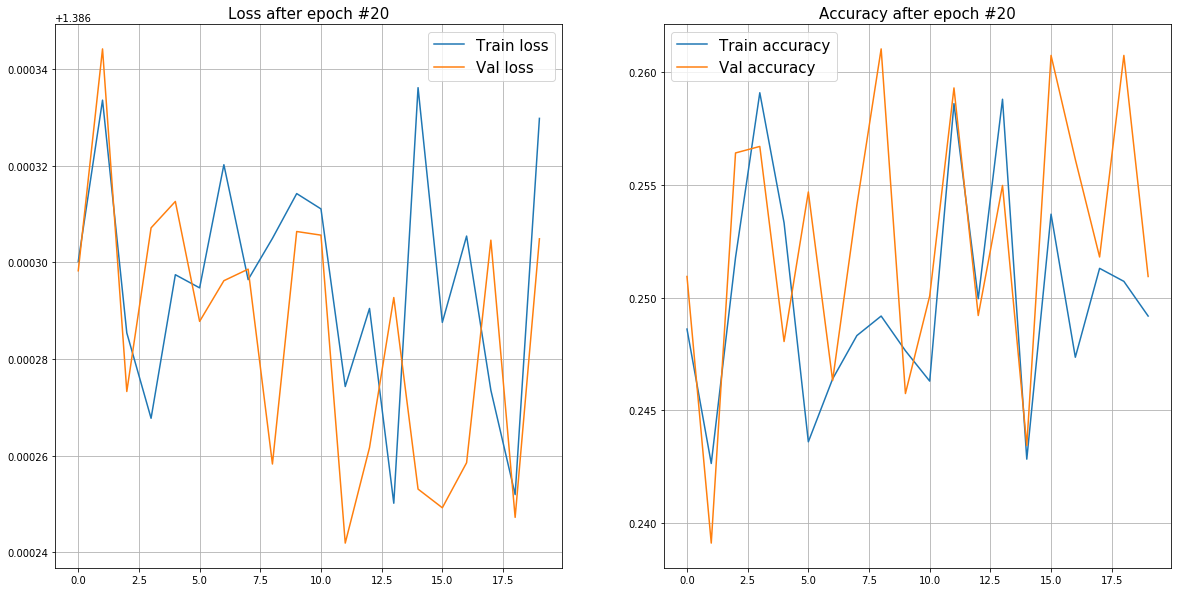

100% (20 of 20) |########################| Elapsed Time: 0:25:04 Time:  0:25:04


SyntaxError: ignored

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
all_train_loss, all_val_loss = [], []
all_train_acc, all_val_acc = [], []
all_scores = []
max_acc = 0

for epoch in pb(range(epochs)):
    cur_train = train(model, optimizer, X_train, y_train, 32)
    cur_val = validate(model, optimizer, X_test, y_test, 16)
    all_train_loss.append(cur_train[0])
    all_train_acc.append(cur_train[1][0])
    all_val_loss.append(cur_val[0])
    all_val_acc.append(cur_val[1][0])
    all_scores.append(cur_val[1])
    max_acc = cur_val[1][0] if cur_val[1][0] > max_acc else max_acc
    clear_output()
    print('Epoch {}:'.format(epoch+1))
    print("Train loss: {}".format(cur_train[0]))
    print("Validation loss: {}".format(cur_val[0]))
    print("Train accuracy: {}".format(cur_train[1][0]))
    print("Validation accuracy: {}".format(cur_val[1][0]))
    print("Max validation accuracy: {}".format(max_acc))

    f, axarr = plt.subplots(1,2, figsize=(20,10))

    axarr[0].plot(all_train_loss, label='Train loss')
    axarr[0].plot(all_val_loss, label='Val loss')
    axarr[0].grid()
    axarr[0].legend(fontsize=15)
    axarr[0].set_title('Loss after epoch #{}'.format(epoch+1), size=15)

    axarr[1].plot(all_train_acc, label='Train accuracy')
    axarr[1].plot(all_val_acc, label='Val accuracy')
    axarr[1].grid()
    axarr[1].legend(fontsize=15)
    axarr[1].set_title('Accuracy after epoch #{}'.format(epoch+1), size=15)
    plt.show()

all_scores = np.max(np.array(all_scores), axis=0)


In [148]:
all_scores

array([0.26103259, 0.26104404, 0.26103259, 0.26063356, 0.26103259])